In [128]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [129]:
data = pd.read_csv('/kaggle/input/amazon-top-50-bestselling-books-2009-2019/bestsellers with categories.csv')

In [130]:
data

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
...,...,...,...,...,...,...,...
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction
546,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2016,Non Fiction
547,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2017,Non Fiction
548,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2018,Non Fiction


In [131]:
stop_words = stopwords.words('english')

def process_name(name):
    name = re.sub('\d+',' ',name)
    name = name.split()
    name = " ".join([word for word in name if word not in stop_words ])
    return name

In [132]:
names = data['Name'].apply(process_name)
data = data.drop('Name',axis=1)

In [133]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(names)
names_token = tokenizer.texts_to_sequences(names)


v_len = len(tokenizer.index_word)
shap = np.max(list(map(lambda x: len(x),names_token)))

In [134]:
names = pad_sequences(names_token,maxlen=11,padding='post')

In [135]:
cols = ['Author']
prefs = ['A_','G_']

for col , prefix in zip(cols,prefs):

    dummie = pd.get_dummies(data[col],prefix=prefix).astype(np.float)
    data = pd.concat([data,dummie],axis=1)
    data = data.drop(col,axis=1)
    
data['Genre'] = data['Genre'].apply(lambda x: 1 if x=='Fiction' else 0)

/tmp/ipykernel_32/2526816462.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dummie = pd.get_dummies(data[col],prefix=prefix).astype(np.float)


In [136]:
y = data['Genre'].copy()
x = data.drop('Genre',axis=1).copy()

In [137]:
y.shape

(550,)

In [138]:
names.shape

(550, 11)

In [139]:
train_name , test_name , x_train , x_test , y_train , y_test = train_test_split(names,x,y,train_size=0.724,random_state=13)

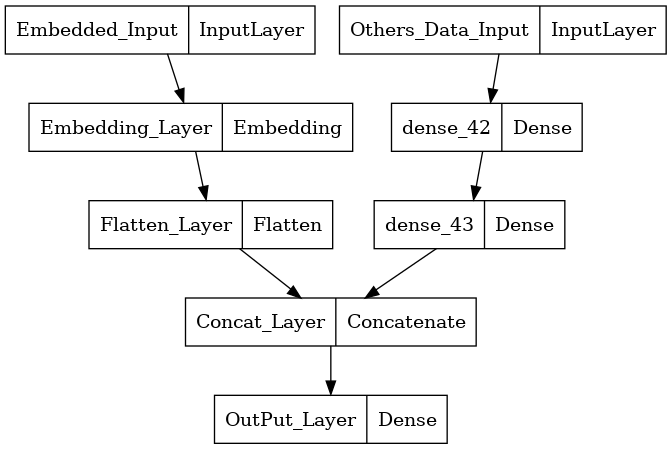

In [142]:
input_name = tf.keras.Input(shape=(11,),name='Embedded_Input')
embedd = tf.keras.layers.Embedding(
    input_dim=v_len+1,
    output_dim=64,
    input_length=710,
    name='Embedding_Layer'
)(input_name)

flatten = tf.keras.layers.Flatten(name='Flatten_Layer')(embedd)

input_other = tf.keras.Input(shape=(252,),name='Others_Data_Input')
layer_1 = tf.keras.layers.Dense(256,activation='relu')(input_other)
layer_2 = tf.keras.layers.Dense(256,activation='relu')(layer_1)

concat = tf.keras.layers.concatenate([flatten,layer_2],name='Concat_Layer')
outputs = tf.keras.layers.Dense(1,activation='sigmoid',name='OutPut_Layer')(concat)

model = tf.keras.Model(inputs=[input_name,input_other],outputs=outputs)

tf.keras.utils.plot_model(model)

In [143]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc')
             ]
)

hist = model.fit(

    [train_name,x_train],
    y_train,
    validation_split = 0.12,
    batch_size=25,
    epochs=100,
    callbacks=tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

)

Epoch 1/100
14/14 [==============================] - 2s 39ms/step - loss: 121.8422 - accuracy: 0.5200 - auc: 0.5352 - val_loss: 242.2835 - val_accuracy: 0.6042 - val_auc: 0.5000
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 84.8557 - accuracy: 0.5686 - auc: 0.5648 - val_loss: 18.0390 - val_accuracy: 0.6875 - val_auc: 0.6316
Epoch 3/100
14/14 [==============================] - 0s 9ms/step - loss: 29.7830 - accuracy: 0.5457 - auc: 0.5442 - val_loss: 17.1225 - val_accuracy: 0.4583 - val_auc: 0.5871
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 26.9069 - accuracy: 0.5543 - auc: 0.5445 - val_loss: 7.8429 - val_accuracy: 0.7292 - val_auc: 0.6987
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 9.8640 - accuracy: 0.5886 - auc: 0.6025 - val_loss: 1.8041 - val_accuracy: 0.7500 - val_auc: 0.7196
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 8.6246 - accuracy: 0.5714 - auc: 0.5804 - val_loss: 

### https://www.kaggle.com/datasets/sootersaalu/amazon-top-50-bestselling-books-2009-2019